In [2]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import CLIPModel, CLIPProcessor
import os

class TensorDataset(Dataset):
    def __init__(self, tensor_dir, num_pos=2, num_neg=2):
        
        self.tensor_paths = [os.path.join(tensor_dir, t) 
                            for t in os.listdir(tensor_dir) if t.endswith('.pt')]

        self.num_pos = num_pos
        self.num_neg = num_neg
        self.num_instances = num_pos + num_neg
        
    def __len__(self):
        return len(self.tensor_paths) // (self.num_instances)

    def __getitem__(self, idx):
        '''
        returns positive and negative combined embeddings in one vector
        '''
        pos_tensor_paths = self.tensor_paths[idx*self.num_instances : idx*self.num_instances + self.num_pos]
        neg_tensor_paths = self.tensor_paths[idx*self.num_instances + self.num_pos : (idx+1)*self.num_instances]
        
        pos_tensors = [torch.load(path) for path in pos_tensor_paths]
        neg_tensors = [torch.load(path) for path in neg_tensor_paths]
        
        pos_combined = torch.prod(torch.stack(pos_tensors), dim=0)
        neg_combined = torch.max(torch.stack(neg_tensors), dim=0).values

        pos_prob = pos_combined.softmax(dim=-1)
        neg_prob = neg_combined.softmax(dim=-1)
        
        combined_probs = torch.cat((pos_prob, neg_prob), dim=1)

        return combined_probs

class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(3230, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 1615)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

def cos_sim_loss(output, inputs):
    pos_inputs, neg_inputs = inputs.split(1615, dim=-1)
    pos_inputs = pos_inputs.squeeze(1)
    neg_inputs = neg_inputs.squeeze(1)
    output = output.squeeze(1)
    
    pos_loss = 1 - F.cosine_similarity(output, pos_inputs, dim=-1)
    neg_loss = F.cosine_similarity(output, neg_inputs, dim=-1)

    loss = pos_loss + neg_loss

    return loss.mean()

def train_model(model, train_loader, val_loader, optimizer, num_epochs):
    train_loss_all = []
    val_loss_all = []
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training step
        for inputs in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = cos_sim_loss(outputs, inputs)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation step
        model.eval()
        with torch.no_grad():
            for inputs in val_loader:
                outputs = model(inputs)
                loss = cos_sim_loss(outputs, inputs)
                val_loss += loss.item()
        model.train()

        train_loss_all.append(train_loss)
        val_loss_all.append(val_loss)
        
        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    return train_loss_all, val_loss_all

/home/jans26/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()

tensor_dir = "Images/coco_val2017/new_tensors"  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TensorDataset(tensor_dir)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  
val_size = dataset_size - train_size  

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)   

model = CustomNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)

train_loss_per_epoch, val_loss_per_epoch = train_model(model, train_loader, val_loader, optimizer, num_epochs=500)


/tmp/ipykernel_1501050/2898456842.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pos_tensors = [torch.load(path) for path in pos_tensor_paths]
/tmp/ipykernel_1501050/2

Epoch [1/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [2/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [3/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [4/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [5/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [6/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [7/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [8/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [9/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [10/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [11/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [12/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [13/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [14/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [15/500], Training Loss: 0.9999, Validation Loss: 0.9999
Epoch [16/500], Training Loss: 0.9999, Validation Loss: 0.9999
E

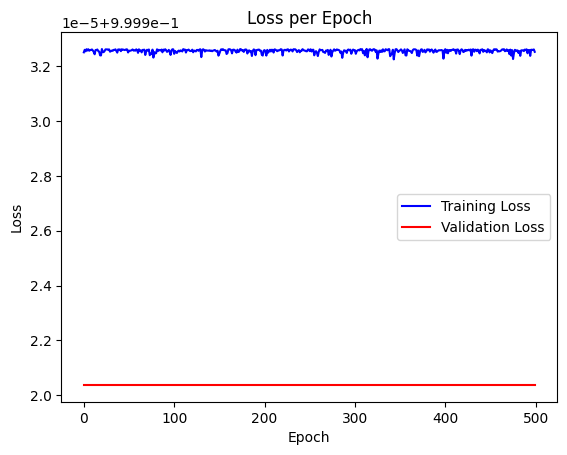

In [7]:
import matplotlib.pyplot as plt

x = range(len(train_loss_per_epoch))

norm_train_loss = []
norm_val_loss = []

for l in train_loss_per_epoch:
    norm_train_loss.append(l/len(train_loader))

for l in val_loss_per_epoch:
    norm_val_loss.append(l/len(val_loader))
    
# Plot the first line
plt.plot(x, norm_train_loss, label='Training Loss', color='blue')

# Plot the second line
plt.plot(x, norm_val_loss, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')

# Add a legend
plt.legend()